In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tnrange
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import copy
from IPython import display
import time
import sys
import japanize_matplotlib

import requests
import json

import MeCab
import re
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA

import sys
sys.path.append("../input")
from API_key import apikey

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression

/home/ku-miyazaki/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
<ipython-input-1-2fe73857f665>:31: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
with open('toxic_scores_comment_en_all.pickle', mode='rb') as f:
    tmp_dict = pickle.load(f)
    
tmp_tmp_dict = {}
for i in tmp_dict:
    tmp_tmp_dict[i] = tmp_dict[i]['attributeScores']['TOXICITY']['summaryScore']["value"]


with open('deep_senti_comment.pickle', mode='rb') as f:
    tmp_dict_id_senti = pickle.load(f)

df_id_senti = pd.DataFrame(tmp_dict_id_senti).T

with open('df_comments_all.pickle', mode='rb') as f:
    df_comments_all = pickle.load(f)

df_comments_all["author_id"] = df_comments_all["authorChannelUrl"].apply(lambda x: x.strip("http://www.youtube.com/channel/"))

df_comments_all["toxicity"] = df_comments_all["id"].map(tmp_tmp_dict)

df_comments_all = df_comments_all.merge(df_id_senti, left_on="id", right_index=True)

df_comments_all = df_comments_all[df_comments_all["fear"].map(type) == float]
df_comments_all["fear"] = df_comments_all["fear"].astype(float)
df_comments_all = df_comments_all[df_comments_all["toxicity"].notnull()]

df_comments_all["commentCountsByVideo"] = df_comments_all["videoId"].map(df_comments_all["videoId"].value_counts().to_dict())

df_comments_all = df_comments_all[df_comments_all["commentCountsByVideo"] >= 10]

Feature building

In [3]:
df_regression = pd.concat([
    df_comments_all.groupby("videoId")["toxicity"].mean(),
    df_comments_all.groupby("videoId")["toxicity"].max(),
    df_comments_all.groupby("videoId")["fear"].mean(),
    df_comments_all.groupby("videoId")["fear"].max(),
    np.log(df_comments_all["videoId"].value_counts())
], axis=1)
df_regression.columns = ["comment_toxicity_mean", "comment_toxicity_max", "comment_fear_mean", "comment_fear_max", "commentCounts"]

In [4]:
high_toxicity_thre = df_comments_all["toxicity"].quantile(0.8)
high_fear_thre = df_comments_all["fear"].quantile(0.8)

In [5]:
dict_toxicity = {}
dict_fear = {}
for c, ind_ in tqdm(enumerate(df_comments_all["videoId"].value_counts().index)):
    tmp_df = df_comments_all[df_comments_all["videoId"] == ind_]
    tmp_df = tmp_df.sort_values("publishedAt").reset_index()
    dict_toxicity[ind_] = (tmp_df["toxicity"] > high_toxicity_thre).sum() / len(tmp_df)
    dict_fear[ind_] = (tmp_df["fear"] > high_toxicity_thre).sum() / len(tmp_df)

0it [00:00, ?it/s]

In [6]:
df_regression["comment_toxicity_ratio"] = df_regression.index.map(dict_toxicity)
df_regression["comment_fear_ratio"] = df_regression.index.map(dict_fear)

In [7]:
json_file_path = "../input/groundtruth_dataset.json" # from original dataset
df_videos = pd.DataFrame([json.loads(line)
        for line in open(json_file_path, 'r', encoding='utf-8')])

In [8]:
df_videos = pd.concat([
    df_videos,
    df_videos["annotation"].apply(lambda x: pd.Series(x)),
    df_videos["statistics"].apply(lambda x: pd.Series(x)),
    df_videos["snippet"].apply(lambda x: pd.Series(x)),
], axis=1)

In [9]:
df_videos = df_videos[df_videos["id"].isin(df_regression.index)]

In [10]:
#  pseudoscience
dict_videoid_label = df_videos.set_index("id")['label'].map(
    {
        'pseudoscience': 1,
        "science": 0,
        'irrelevant': 0
    }
).to_dict()
df_regression["pseudoscience"] = df_regression.index.map(dict_videoid_label)

In [11]:
# view count （numerical value（logged））
dict_videoid_viewCount = df_videos.set_index("id")["viewCount"].astype(int).map(np.log).to_dict()
df_regression["viewCount"] = df_regression.index.map(dict_videoid_viewCount)

In [12]:
# life / dislike（numerical value）
dict_videoid_likeRatio = (df_videos.set_index("id")["likeCount"].fillna(0).astype(int) / \
(df_videos.set_index("id")["likeCount"].fillna(0).astype(int) + \
df_videos.set_index("id")["dislikeCount"].fillna(0).astype(int))).to_dict()
df_regression["dict_videoid_likeRatio"] = df_regression.index.map(dict_videoid_likeRatio)

In [13]:
# video date
df_videos["publishedAt"] = df_videos["publishedAt"].map(pd.Timestamp)
df_videos["published_day"] = (df_videos["publishedAt"] - min(df_videos["publishedAt"])).apply(lambda x: x.days)
dict_videoid_publishday = df_videos.set_index("id")["published_day"].to_dict()
df_regression["dict_videoid_publishday"] = df_regression.index.map(dict_videoid_publishday)

In [14]:
# title
with open('deep_senti_title.pickle', mode='rb') as f:
    dict_title_sentiment = pickle.load(f)

In [15]:
df_regression["title_fear"] = df_regression.apply(lambda x: dict_title_sentiment[x.name]["fear"] if dict_title_sentiment[x.name] != "error" else None, axis=1)

In [16]:
with open('toxic_scores_title_en.pickle', mode='rb') as f:
    dict_title_toxicity = pickle.load(f)

In [17]:
df_regression["title_toxicity"] = df_regression.apply(lambda x: dict_title_toxicity[x.name]['attributeScores']['INSULT']['summaryScore']["value"] if x.name in  dict_title_toxicity else None, axis=1)


In [18]:
# description
with open('deep_senti_description.pickle', mode='rb') as f:
    dict_description_sentiment = pickle.load(f)

In [19]:
df_regression["description_fear"] = df_regression.apply(lambda x: dict_description_sentiment[x.name]["fear"] if dict_description_sentiment[x.name] != "error" else None, axis=1)


In [20]:
with open('toxic_scores_description_en.pickle', mode='rb') as f:
    dict_description_toxicity = pickle.load(f)

In [21]:
df_regression["description_toxicity"] = df_regression.apply(lambda x: dict_description_toxicity[x.name]['attributeScores']['INSULT']['summaryScore']["value"] if x.name in  dict_description_toxicity else None, axis=1)


In [22]:
# subscriber count
with open('tmp_dict_chennelid_info.pickle', mode='rb') as f:
    tmp_dict_chennelid_info = pickle.load(f)

In [23]:
videoId_channelId = df_videos.set_index("id")["channelId"].to_dict()

In [24]:
tmp_subscriber_count = []
for videoId in df_regression.index:
    channel_id =  videoId_channelId[videoId]
    if channel_id  in tmp_dict_chennelid_info:
        resource = tmp_dict_chennelid_info[channel_id ]
        if "items" in resource:
            tmp_subscriber_count.append(resource['items'][0]['statistics']['subscriberCount'])
        else:
            tmp_subscriber_count.append(None)
    else:
        tmp_subscriber_count.append(None)

In [25]:
df_regression["subscriber_count"] = tmp_subscriber_count

In [26]:
df_regression = df_regression[df_regression["subscriber_count"].notnull()]

In [27]:
df_regression["subscriber_count"] = df_regression["subscriber_count"].astype(int).map(np.log)

In [28]:
df_regression["subscriber_count"].isnull().sum()

0

In [29]:
# video fear
with open('deep_senti_caption.pickle', mode='rb') as f:
    dict_caption_sentiment = pickle.load(f)

In [30]:
df_regression["caption_fear"] = df_regression.apply(lambda x: dict_caption_sentiment[x.name]["fear"] if dict_caption_sentiment[x.name] != "error" else None, axis=1)


In [31]:
# video toxicity
with open('toxic_scores_captions.pickle', mode='rb') as f:
    dict_caption_toxicity = pickle.load(f)

In [32]:
df_regression["caption_toxicity"] = df_regression.apply(lambda x: dict_caption_toxicity[x.name]['attributeScores']['INSULT']['summaryScore']["value"] if x.name in  dict_caption_toxicity else None, axis=1)


In [33]:
df_regression["caption_toxicity"].isnull().sum()

304

In [34]:
# topics
with open('df_transcripts_topic.pickle', mode='rb') as f:
    df_transcripts = pickle.load(f)

In [35]:
df_transcripts = df_transcripts.set_index("id")

In [36]:
df_transcripts.head()

,_id,captions,captions_concat,captions_concat_cleansed,topic
id,,,,,
b03U6BYF9L0,{'$oid': '6035c1b049d40868d8970374'},[The number of people that are against vaccina...,The number of people that are against vaccinat...,"[number, child, year, claim, argument, fact, e...",4
HFHBPvMRvX4,{'$oid': '6035c1b049d40868d8970376'},"[Anti-vaxxers, I've heard of them., But a lot ...","Anti-vaxxers, I've heard of them. But a lot of...","[lot, movement, generation, thing, fringe, mon...",4
VQti02x57bE,{'$oid': '6035c1b049d40868d8970378'},"[ , measles is a disease that we eliminated, f...",measles is a disease that we eliminated from...,"[measles, disease, state, education, coercion,...",4
kuDzdWG8OsI,{'$oid': '6035c1b149d40868d897037a'},"[SITES. NBC’S KRISTEN DAHLGREN PICKING, NBC’S ...",SITES. NBC’S KRISTEN DAHLGREN PICKING NBC’S KR...,"[site, ’, story, story, morning, morning, morn...",4
V522Hs8E6NU,{'$oid': '6035c1b149d40868d897037c'},"[ , they're destroying the lives of, countless...",they're destroying the lives of countless ch...,"[theyre, life, child, leader, movement, autism...",4


In [37]:
df_topics_caption = pd.get_dummies(df_transcripts["topic"]).loc[:, [0, 1,3,4,5]]

In [38]:
df_topics_caption.columns = ["topic_0", "topic_1",  "topic_3", "topic_4", "topic_5"]

In [39]:
df_topics_caption

,topic_0,topic_1,topic_3,topic_4,topic_5
id,,,,,
b03U6BYF9L0,0,0,0,1,0
HFHBPvMRvX4,0,0,0,1,0
VQti02x57bE,0,0,0,1,0
kuDzdWG8OsI,0,0,0,1,0
V522Hs8E6NU,0,0,0,1,0
...,...,...,...,...,...
xs6aUwZAGTQ,0,0,0,0,1
0Zb9v1nsRpw,0,0,0,0,1
KdseVBWbw2w,0,0,0,1,0


In [40]:
df_regression = pd.concat([
    df_regression,
    df_topics_caption
], axis=1)

In [41]:
df_regression = df_regression[df_regression["comment_toxicity_mean"].notnull()]

In [42]:
df_regression = df_regression[df_regression['dict_videoid_likeRatio'].notnull()]

In [43]:
df_regression = df_regression[df_regression['title_toxicity'].notnull()]
df_regression = df_regression[df_regression['description_toxicity'].notnull()]

In [44]:
df_regression.iloc[:, -1].isnull().sum()

129

In [45]:
import scipy

In [46]:
from sklearn.preprocessing import MinMaxScaler

In [47]:
df_regression.describe()

,comment_toxicity_mean,comment_toxicity_max,comment_fear_mean,comment_fear_max,commentCounts,comment_toxicity_ratio,comment_fear_ratio,pseudoscience,viewCount,dict_videoid_likeRatio,...,description_fear,description_toxicity,subscriber_count,caption_fear,caption_toxicity,topic_0,topic_1,topic_3,topic_4,topic_5
count,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,...,1072.000000,1072.000000,1072.000000,978.000000,785.000000,943.000000,943.000000,943.000000,943.000000,943.000000
mean,0.166026,0.795717,0.056482,0.865256,5.535218,0.184064,0.055210,0.191231,12.205318,0.929997,...,0.189026,0.042650,13.617948,0.179060,0.142736,0.075292,0.195122,0.262990,0.170732,0.124072
std,0.053641,0.181213,0.033728,0.249284,1.549534,0.097604,0.043152,0.393454,1.977739,0.099072,...,0.285429,0.085101,2.098844,0.279576,0.141508,0.264001,0.396505,0.440491,0.376474,0.329839
min,0.018417,0.026551,0.002280,0.006569,2.302585,0.000000,0.000000,0.000000,4.304065,0.216102,...,0.000375,0.005211,6.025866,0.000309,0.007798,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.129395,0.734456,0.033806,0.908705,4.290459,0.115803,0.026970,0.000000,10.830803,0.926999,...,0.007099,0.011427,12.413087,0.010786,0.038859,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.164548,0.869678,0.049456,0.980664,5.746198,0.181013,0.045116,0.000000,12.327744,0.963079,...,0.039565,0.018065,13.591638,0.051363,0.079988,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.201471,0.918938,0.072485,0.990332,6.885765,0.245118,0.074228,0.000000,13.615921,0.978431,...,0.235069,0.030513,15.260074,0.175118,0.202012,0.000000,0.000000,1.000000,0.000000,0.000000
max,0.367807,0.987534,0.233402,0.995827,7.599401,0.739940,0.321429,1.000000,17.380852,1.000000,...,0.991223,0.658656,17.460960,0.991478,0.788825,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
df_regression

,comment_toxicity_mean,comment_toxicity_max,comment_fear_mean,comment_fear_max,commentCounts,comment_toxicity_ratio,comment_fear_ratio,pseudoscience,viewCount,dict_videoid_likeRatio,...,description_fear,description_toxicity,subscriber_count,caption_fear,caption_toxicity,topic_0,topic_1,topic_3,topic_4,topic_5
-1L9MM_NEVg,0.260054,0.925492,0.104556,0.987606,7.089243,0.337781,0.115096,0.0,12.639046,0.983622,...,0.023191,0.017937,13.538439,0.029885,0.168538,0.0,0.0,0.0,0.0,0.0
-PLVGzAG23c,0.131685,0.907424,0.048900,0.970012,6.230481,0.114173,0.043307,0.0,12.287897,0.983958,...,0.719367,0.029273,15.797890,0.051363,NaN,NaN,NaN,NaN,NaN,NaN
-PdvvEMm3vU,0.220720,0.907424,0.037378,0.978331,4.488636,0.269663,0.022472,1.0,9.639587,0.924312,...,0.020326,0.030375,14.038654,0.051363,NaN,NaN,NaN,NaN,NaN,NaN
-VpEU3utSJE,0.054481,0.713827,0.051429,0.986744,4.317488,0.026667,0.040000,0.0,9.803943,0.976378,...,0.289048,0.009983,13.316284,0.005464,NaN,1.0,0.0,0.0,0.0,0.0
-cS8VaQno3g,0.223984,0.935843,0.044405,0.985912,6.502790,0.271364,0.041979,0.0,12.883852,0.943628,...,0.001995,0.010895,11.911702,0.006431,0.244933,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zdfe7-qIzgs,0.171977,0.954731,0.057888,0.993444,7.550661,0.182965,0.052576,1.0,15.017315,0.979034,...,0.017129,0.020644,15.454507,0.959309,0.084594,0.0,0.0,0.0,1.0,0.0
zoRLf7YvGFQ,0.181484,0.869678,0.045574,0.992519,5.252273,0.188482,0.036649,0.0,11.909726,0.993586,...,0.001590,0.009337,12.154779,0.008749,NaN,0.0,0.0,0.0,0.0,0.0
ztkNLWFgYH8,0.139256,0.886517,0.060725,0.991903,6.522093,0.136765,0.066176,0.0,14.017350,0.967416,...,0.004039,0.009280,14.834358,0.065577,0.061452,1.0,0.0,0.0,0.0,0.0
zywkzIBVEDk,0.148626,0.595890,0.054977,0.985084,4.465908,0.149425,0.045977,0.0,11.274922,0.949838,...,0.048630,0.016177,14.528460,0.051363,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
scaler = MinMaxScaler()

In [50]:
df_regression = pd.DataFrame(scaler.fit_transform(df_regression), index=df_regression.index, columns=df_regression.columns)

In [51]:
scipy.stats.pearsonr(df_regression[
                            (df_regression["caption_fear"].notnull())&(df_regression["caption_toxicity"].notnull())
                        ]["caption_fear"], 
                    df_regression[
                         (df_regression["caption_fear"].notnull())&(df_regression["caption_toxicity"].notnull())
                     ]["caption_toxicity"])


PearsonRResult(statistic=-0.07474662045578964, pvalue=0.04695163508128354)

In [52]:
df_regression.columns

Index(['comment_toxicity_mean', 'comment_toxicity_max', 'comment_fear_mean',
       'comment_fear_max', 'commentCounts', 'comment_toxicity_ratio',
       'comment_fear_ratio', 'pseudoscience', 'viewCount',
       'dict_videoid_likeRatio', 'dict_videoid_publishday', 'title_fear',
       'title_toxicity', 'description_fear', 'description_toxicity',
       'subscriber_count', 'caption_fear', 'caption_toxicity', 'topic_0',
       'topic_1', 'topic_3', 'topic_4', 'topic_5'],
      dtype='object')

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [54]:
df_regression_1 = df_regression.loc[:, [
    'comment_fear_mean',
    'pseudoscience', 
    'viewCount',
    'dict_videoid_likeRatio', 
    "dict_videoid_publishday",
    "subscriber_count"
]]

In [55]:
df_regression_1 = df_regression_1[df_regression_1["subscriber_count"].notnull()]

In [56]:
df_regression_1.isnull().sum()

comment_fear_mean          0
pseudoscience              0
viewCount                  0
dict_videoid_likeRatio     0
dict_videoid_publishday    0
subscriber_count           0
dtype: int64

In [57]:
df_regression_1_x = df_regression_1.loc[:, [i for i in df_regression_1.columns if i != 'comment_fear_mean'] ]
df_regression_1_y = df_regression_1['comment_fear_mean'] 

In [58]:
from statsmodels.tools.tools import add_constant

In [59]:
#vif
vif = pd.DataFrame()
X = add_constant(df_regression_1_x)

vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
 
print(vif)
 

   VIF Factor                 features
0   93.689141                    const
1    1.019418            pseudoscience
2    1.388253                viewCount
3    1.191309   dict_videoid_likeRatio
4    1.074477  dict_videoid_publishday
5    1.180366         subscriber_count


In [60]:
import statsmodels.api as sm

In [61]:
y = df_regression_1_y
X = add_constant(df_regression_1_x)

lr = sm.OLS(y, X)
lr_result = lr.fit()
print(lr_result.params)
print(lr_result.summary())

y_pred = lr.predict(lr_result.params)
# plt.scatter(x.ravel(), y_pred, c="b", al

const                      0.418947
pseudoscience              0.033174
viewCount                 -0.072583
dict_videoid_likeRatio    -0.202397
dict_videoid_publishday    0.029268
subscriber_count           0.020640
dtype: float64
                            OLS Regression Results                            
Dep. Variable:      comment_fear_mean   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     13.39
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           1.11e-12
Time:                        07:54:53   Log-Likelihood:                 575.24
No. Observations:                1072   AIC:                            -1138.
Df Residuals:                    1066   BIC:                            -1109.
Df Model:                           5                                         
Covariance Type:            nonrobust                     

In [62]:
tmp_df_result = pd.read_html(lr_result.summary().tables[1].as_html() ,header=0, index_col=0)[0]
tmp_list_result1 = []
for ind_, row in tmp_df_result.iterrows():
    if row["P>|t|"] < 0.001:
        signi = "***"
    elif row["P>|t|"] < 0.01:
        signi = "**"
    elif row["P>|t|"] < 0.05:
        signi = "*"
    else:
        signi = ""
    tmp_list_result1.append(
        "{:.3f}".format(row["coef"]) + signi
    )

In [63]:
tmp_list_result1 += [
    "{:.3f}".format(lr_result.rsquared),
    "{:,}".format(len(df_regression_1_x))
]

In [64]:
tmp_list_result1 = pd.DataFrame(tmp_list_result1, index=list(tmp_df_result.index)+["R-squ.", "N"], columns = ["Model1"])
tmp_list_result1

,Model1
const,0.419***
pseudoscience,0.033**
viewCount,-0.073*
dict_videoid_likeRatio,-0.202***
dict_videoid_publishday,0.029
subscriber_count,0.021
R-squ.,0.059
N,"1,072"


In [65]:
df_regression_2 = df_regression.loc[:, [
    'comment_fear_mean',
    'pseudoscience', 
    'viewCount',
    "dict_videoid_publishday",
    'dict_videoid_likeRatio', 
    "subscriber_count",
    "title_fear",
    "description_fear",
    'caption_fear', 
    "title_toxicity",
    "description_toxicity",
    'caption_toxicity',
    'topic_0',
    'topic_1',
    'topic_3',
    'topic_4',
    'topic_5'
]]

In [66]:
df_regression_2 = df_regression_2[df_regression_2["caption_toxicity"].notnull()]
df_regression_2 = df_regression_2[df_regression_2["caption_fear"].notnull()]

In [67]:
df_regression_2_x = df_regression_2.loc[:, [i for i in df_regression_2.columns if i != 'comment_fear_mean'] ]
df_regression_2_y = df_regression_2['comment_fear_mean'] 

In [68]:
#vif
vif = pd.DataFrame()
X = add_constant(df_regression_2_x)

vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
 
print(vif)
 

    VIF Factor                 features
0   111.978879                    const
1     1.045279            pseudoscience
2     1.600092                viewCount
3     1.140640  dict_videoid_publishday
4     1.354148   dict_videoid_likeRatio
5     1.321155         subscriber_count
6     1.180023               title_fear
7     1.136339         description_fear
8     1.136789             caption_fear
9     1.197381           title_toxicity
10    1.174688     description_toxicity
11    1.256450         caption_toxicity
12    1.395169                  topic_0
13    1.777209                  topic_1
14    2.053482                  topic_3
15    2.028975                  topic_4
16    1.523937                  topic_5


In [69]:
y = df_regression_2_y
X = add_constant(df_regression_2_x)

lr = sm.OLS(y, X)
lr_result = lr.fit()
print(lr_result.params)
print(lr_result.summary())

y_pred = lr.predict(lr_result.params)

const                      0.197529
pseudoscience              0.011371
viewCount                  0.026375
dict_videoid_publishday    0.045973
dict_videoid_likeRatio    -0.078647
subscriber_count          -0.022532
title_fear                 0.141038
description_fear           0.058307
caption_fear               0.079443
title_toxicity             0.036645
description_toxicity       0.005228
caption_toxicity          -0.023474
topic_0                    0.083551
topic_1                   -0.008879
topic_3                    0.016532
topic_4                    0.096435
topic_5                    0.031038
dtype: float64
                            OLS Regression Results                            
Dep. Variable:      comment_fear_mean   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     12.93
Date:                Tue, 19 Dec 2023   Prob (F-statistic

In [70]:
tmp_df_result = pd.read_html(lr_result.summary().tables[1].as_html() ,header=0, index_col=0)[0]
tmp_list_result2 = []
for ind_, row in tmp_df_result.iterrows():
    if row["P>|t|"] < 0.001:
        signi = "***"
    elif row["P>|t|"] < 0.01:
        signi = "**"
    elif row["P>|t|"] < 0.05:
        signi = "*"
    else:
        signi = ""
    tmp_list_result2.append(
        "{:.3f}".format(row["coef"]) + signi
    )

In [71]:
tmp_list_result2 += [
    "{:.3f}".format(lr_result.rsquared),
    "{:,}".format(len(df_regression_2_x))
]

In [72]:
tmp_list_result2 = pd.DataFrame(tmp_list_result2, index=list(tmp_df_result.index)+["R-squ.", "N"], columns = ["Model2"])
tmp_list_result2

,Model2
const,0.198***
pseudoscience,0.011
viewCount,0.026
dict_videoid_publishday,0.046
dict_videoid_likeRatio,-0.079
subscriber_count,-0.022
title_fear,0.141***
description_fear,0.058**
caption_fear,0.079***
title_toxicity,0.037


In [73]:
df_regression_3 = df_regression.loc[:, [
    'comment_fear_mean',
    'pseudoscience', 
    'viewCount',
    'dict_videoid_likeRatio', 
    "dict_videoid_publishday",
    "subscriber_count",
    "title_fear",
    "description_fear",
    'caption_fear', 
    "title_toxicity",
    "description_toxicity",
    'caption_toxicity',
    'topic_0',
    'topic_1',
    'topic_3',
    'topic_4',
    'topic_5',
    'comment_toxicity_mean', 
    'commentCounts'
]]

In [74]:
df_regression_3 = df_regression_3[df_regression_3["caption_toxicity"].notnull()]

In [75]:
df_regression_3 = df_regression_3[df_regression_3["caption_toxicity"].notnull()]
df_regression_3 = df_regression_3[df_regression_3["caption_fear"].notnull()]

In [76]:
df_regression_3_x = df_regression_3.loc[:, [i for i in df_regression_3.columns if i != 'comment_fear_mean'] ]
df_regression_3_y = df_regression_3['comment_fear_mean'] 

In [77]:
df_regression_3_x.isnull().sum()

pseudoscience              0
viewCount                  0
dict_videoid_likeRatio     0
dict_videoid_publishday    0
subscriber_count           0
title_fear                 0
description_fear           0
caption_fear               0
title_toxicity             0
description_toxicity       0
caption_toxicity           0
topic_0                    0
topic_1                    0
topic_3                    0
topic_4                    0
topic_5                    0
comment_toxicity_mean      0
commentCounts              0
dtype: int64

In [78]:
#vif
vif = pd.DataFrame()
X = add_constant(df_regression_3_x)

vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
 
print(vif)
 

    VIF Factor                 features
0   149.355392                    const
1     1.047507            pseudoscience
2     3.971105                viewCount
3     1.374570   dict_videoid_likeRatio
4     1.262664  dict_videoid_publishday
5     1.338873         subscriber_count
6     1.181127               title_fear
7     1.143519         description_fear
8     1.141109             caption_fear
9     1.221917           title_toxicity
10    1.180338     description_toxicity
11    1.379644         caption_toxicity
12    1.422756                  topic_0
13    1.778637                  topic_1
14    2.063731                  topic_3
15    2.055328                  topic_4
16    1.539912                  topic_5
17    1.433029    comment_toxicity_mean
18    3.422309            commentCounts


In [79]:
y = df_regression_3_y
X = add_constant(df_regression_3_x)

lr = sm.OLS(y, X)
lr_result = lr.fit()
print(lr_result.params)
print(lr_result.summary())

y_pred = lr.predict(lr_result.params)

const                      0.149546
pseudoscience              0.008315
viewCount                 -0.068018
dict_videoid_likeRatio    -0.052420
dict_videoid_publishday    0.016961
subscriber_count          -0.008661
title_fear                 0.138030
description_fear           0.064556
caption_fear               0.082360
title_toxicity             0.010469
description_toxicity      -0.008230
caption_toxicity          -0.068430
topic_0                    0.099058
topic_1                   -0.011267
topic_3                    0.011429
topic_4                    0.097699
topic_5                    0.036925
comment_toxicity_mean      0.177291
commentCounts              0.048596
dtype: float64
                            OLS Regression Results                            
Dep. Variable:      comment_fear_mean   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:            

In [80]:
tmp_df_result = pd.read_html(lr_result.summary().tables[1].as_html() ,header=0, index_col=0)[0]

In [81]:
tmp_df_result

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.1495,0.061,2.458,0.014,0.030,0.269
pseudoscience,0.0083,0.013,0.636,0.525,-0.017,0.034
viewCount,-0.0680,0.066,-1.031,0.303,-0.198,0.062
dict_videoid_likeRatio,-0.0524,0.046,-1.151,0.250,-0.142,0.037
dict_videoid_publishday,0.0170,0.031,0.548,0.584,-0.044,0.078
subscriber_count,-0.0087,0.032,-0.272,0.786,-0.071,0.054
title_fear,0.1380,0.025,5.435,0.000,0.088,0.188
description_fear,0.0646,0.018,3.655,0.000,0.030,0.099
caption_fear,0.0824,0.018,4.704,0.000,0.048,0.117
title_toxicity,0.0105,0.037,0.285,0.776,-0.062,0.083


In [82]:
tmp_list_result3 = []
for ind_, row in tmp_df_result.iterrows():
    if row["P>|t|"] < 0.001:
        signi = "***"
    elif row["P>|t|"] < 0.01:
        signi = "**"
    elif row["P>|t|"] < 0.05:
        signi = "*"
    else:
        signi = ""
    tmp_list_result3.append(
        "{:.3f}".format(row["coef"]) + signi
    )

In [83]:
tmp_list_result3 += [
    "{:.3f}".format(lr_result.rsquared),
    "{:,}".format(len(df_regression_3_x))
]

In [84]:
tmp_list_result3 = pd.DataFrame(tmp_list_result3, index=list(tmp_df_result.index)+["R-squ.", "N"], columns = ["Model3"])
tmp_list_result3

,Model3
const,0.149*
pseudoscience,0.008
viewCount,-0.068
dict_videoid_likeRatio,-0.052
dict_videoid_publishday,0.017
subscriber_count,-0.009
title_fear,0.138***
description_fear,0.065***
caption_fear,0.082***
title_toxicity,0.011


In [85]:
result_summary = pd.concat([
    df_regression_1_x.mean(),
    df_regression_1_x.std(),
#     df_regression_2_x.mean(),
#     df_regression_3_x.std(),
    df_regression_3_x.mean(),
    df_regression_3_x.std()
], axis=1)

In [86]:
tmp_list_mean = []
tmp_list_std = []
for ind_, row in result_summary.iterrows():
    if ind_ in ["pseudoscience", "viewCount", "dict_videoid_likeRatio"]:
        tmp_list_mean.append("{:.2f}".format(row[2]))# + "\n({:.2f})".format(row[0]))
        tmp_list_std.append("{:.2f}".format(row[3]))# + "\n({:.2f})".format(row[1]))
    else:
        tmp_list_mean.append("{:.2f}".format(row[2]))
        tmp_list_std.append("{:.2f}".format(row[3]))

In [87]:
df_result_sum = pd.DataFrame([tmp_list_mean, tmp_list_std], columns=result_summary.index, index=["Mean", "Std"]).T
df_result_sum

,Mean,Std
pseudoscience,0.19,0.39
viewCount,0.60,0.15
dict_videoid_likeRatio,0.91,0.13
dict_videoid_publishday,0.80,0.18
subscriber_count,0.67,0.18
title_fear,0.11,0.21
description_fear,0.20,0.30
caption_fear,0.21,0.30
title_toxicity,0.07,0.15
description_toxicity,0.06,0.13


In [88]:
pd.concat([
    tmp_list_result1,
    tmp_list_result2,
    tmp_list_result3,
    df_result_sum
], axis=1).fillna("-").loc[
    [i for i in tmp_list_result3.index if i not in  ['R-squ.', "N"]] + ['R-squ.', "N"], :
].iloc[
    [0,2,3,1] + list(range(4,len(tmp_list_result3)))
].rename(
    index={
        "pseudoscience": "Pseudoscience",
        "viewCount": "View count",
        "dict_videoid_likeRatio": "Like ratio",
        "dict_videoid_publishday": "Publish date",
        "subscriber_count": "Subscriber count",
        "title_fear": "Fear (title)",
        "title_toxicity": "Toxicity (title)",        
        "caption_fear": "Fear (subtitle)",
        "caption_toxicity": "Toxicity (subtitle)",
        "topic_0": "Topic_virus",
        "topic_1": "Topic_government",
        "topic_3": "Topic_route",
        "topic_4": "Topic_child",
        "topic_5": "Topic_school",
        "comment_toxicity_mean": "Toxicity (comment)",
#         "comment_toxicity_ratio": "Toxicity (comment)",
        "commentCounts": "Comment counts"
    }
)

,Model1,Model2,Model3,Mean,Std
const,0.419***,0.198***,0.149*,-,-
View count,-0.073*,0.026,-0.068,0.60,0.15
Like ratio,-0.202***,-0.079,-0.052,0.91,0.13
Pseudoscience,0.033**,0.011,0.008,0.19,0.39
Publish date,0.029,0.046,0.017,0.80,0.18
Subscriber count,0.021,-0.022,-0.009,0.67,0.18
Fear (title),-,0.141***,0.138***,0.11,0.21
description_fear,-,0.058**,0.065***,0.20,0.30
Fear (subtitle),-,0.079***,0.082***,0.21,0.30
Toxicity (title),-,0.037,0.011,0.07,0.15


In [89]:
import seaborn as sns

In [90]:
import scienceplots
plt.style.use(['science','nature'])
from matplotlib import rc
rc("text", usetex=False)

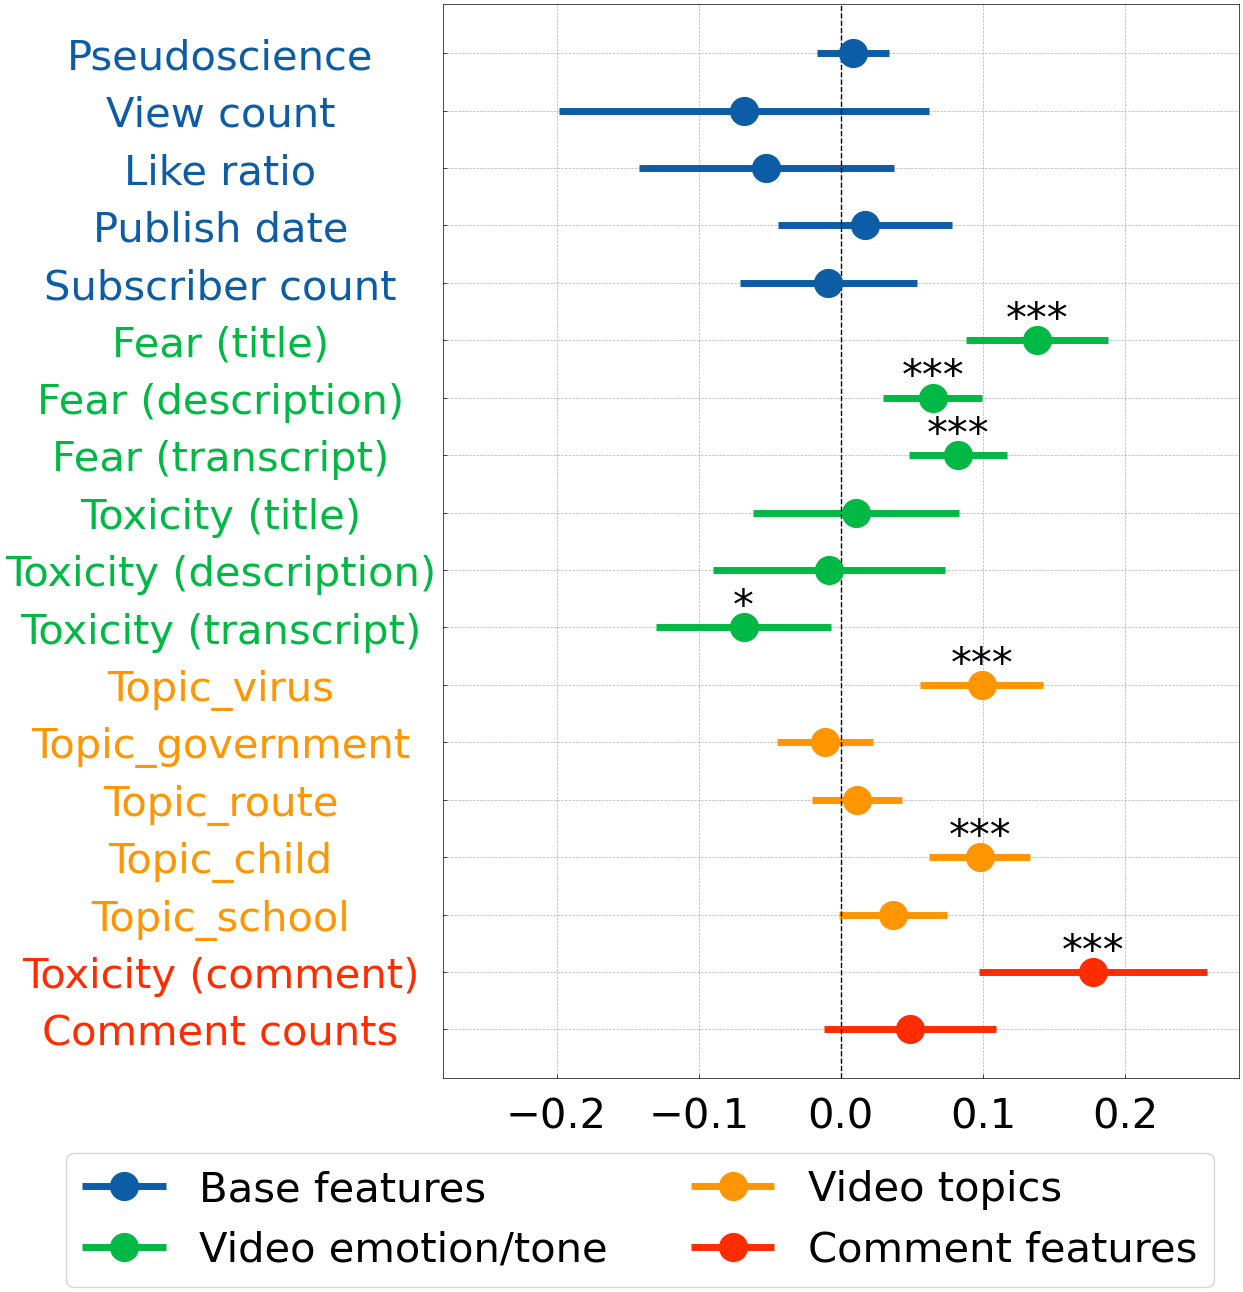

In [91]:
# Define figure, axes, and plot
# fig, ax = plt.subplots(figsize=(16, 13))
fig, ax = plt.subplots(figsize=(13, 13))
list_plot = []
# list_range = [10,20,30,40,50]

    
# Create dataframe of results summary 
coef_df = pd.DataFrame(lr_result.summary().tables[1].data)
# Add column names
coef_df.columns = coef_df.iloc[0]

# Drop the extra row with column labels
coef_df=coef_df.drop(0)

# Set index to variable names 
coef_df = coef_df.set_index(coef_df.columns[0])

# Change datatype from object to float
coef_df = coef_df.astype(float)

# Get errors; (coef - lower bound of conf interval)
errors = coef_df['coef'] - coef_df['[0.025']

# Append errors column to dataframe
coef_df['errors'] = errors

# Drop the constant for plotting
coef_df = coef_df.drop(['const'])

# coef_df = coef_df.loc[[
#     "highlike_toxicity_former",
# #         "highlike_fear_former",
# #         "fear_former",
# #         "lowlike_toxicity_former",
# #         "lowlike_fear_former",
# ], :]

coef_df = coef_df.rename(
    index={
        "pseudoscience": "Pseudoscience",
        "viewCount": "View count",
        "dict_videoid_likeRatio": "Like ratio",
        "dict_videoid_publishday": "Publish date",
        "subscriber_count": "Subscriber count",
        "title_fear": "Fear (title)",
        "title_toxicity": "Toxicity (title)",
        "description_fear": "Fear (description)",
        "description_toxicity": "Toxicity (description)",
        "caption_fear": "Fear (transcript)",
        "caption_toxicity": "Toxicity (transcript)",
        "topic_0": "Topic_virus",
        "topic_1": "Topic_government",
        "topic_3": "Topic_route",
        "topic_4": "Topic_child",
        "topic_5": "Topic_school",
        "comment_toxicity_mean": "Toxicity (comment)",
#         "comment_toxicity_ratio": "Toxicity (comment)",
        "commentCounts": "Comment counts"
    })

list_plot.append(coef_df)


# x-labels
variables = list(coef_df.index.values)

# Add variables column to dataframe
coef_df['variables'] = variables

# coef_df['range'] = range_

    
# Set sns plot style back to 'poster'
# This will make bars wide on plot
# sns.set_context("poster")

# colors = ['red', 'green', 'blue', 'cyan', 'magenta', "black", "pink", "orange"]
colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])

i = 0
xlabel_colors = []
for c, row in coef_df.iterrows():
    if i <5:
        color = colors[0]
    elif (i >= 5) and (i < 11):
        color = colors[1]
    elif (i >= 11) and (i < 16):
        color = colors[2]
    elif i >=16:
        color = colors[3]
    xlabel_colors.append(color)
        
    if i == 0:
        label = "Base features" 
    elif i == 5:
        label = "Video emotion/tone" 
    elif i == 11:
        label = "Video topics" 
    elif i == 16:
        label = "Comment features" 
    else:
        label = None
    ax.errorbar(
        row['coef'],
        i,
        yerr=0,
        xerr=row['errors'],
#         label=c,
        label=label,
        linewidth=5,
        color=color,
        ecolor=color,
        marker='o',
        markersize=20,
        ls=''
    )

    if row["P>|t|"] < 0.001:
        signi = "***"
    elif row["P>|t|"] < 0.01:
        signi = "**"
    elif row["P>|t|"] < 0.05:
        signi = "*"
#     elif row["P>|t|"] < 0.1:
#         signi = "*"
    else:
        signi = ""

    ax.text(
        row['coef'], 
        i,
        signi, 
        size=30,
        ha='center', 
        va='bottom', 
        color="black"
    )


    i += 1



# # # Set title & labels

ax.set_yticks(list(range(len(coef_df.index))))
ax.set_yticklabels(list(coef_df.index),fontsize=22, ha="center")
[t.set_color(xlabel_colors[cc]) for cc, t in enumerate(ax.yaxis.get_ticklabels())]

ax.grid( linestyle='--')

ax.axvline(x=0, linestyle='--', color='black', linewidth=1)
# ax.axvline(x=0.1, linestyle='--', color='black', linewidth=0.5)
# ax.axvline(x=0.2, linestyle='--', color='black', linewidth=0.5)
# ax.axvline(x=-0.1, linestyle='--', color='black', linewidth=0.5)
# ax.axvline(x=-0.2, linestyle='--', color='black', linewidth=0.5)



handles, labels = ax.get_legend_handles_labels()
for i in range(4):
    handles[i] = (handles[i].lines[0], handles[i].lines[1], tuple([handles[i].lines[2][0]]))
ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.5, -0.05), prop=dict(size=30), ncol=2, frameon=True)
# ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 1), prop=dict(size=30), ncol=1)
# ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.3, 1.15), prop=dict(size=30), ncol=2)
    
# ax.set_ylim(-0.4, 0.4)
ax.set_xlim(-0.28, 0.28)
ax.minorticks_off()
ax.xaxis.set_ticks_position('bottom') 
ax.yaxis.set_ticks_position('left') 
# ax.get_yaxis().set_ticks([])
ax.tick_params(axis='x', which='major', labelsize=30, pad=13)
ax.tick_params(axis='y', which='major', labelsize=30, pad=160)
# ax.set_title("Highly-liked toxic comments", size=36, pad=15)

# plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
# plt.savefig("figures/coef_macro2.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()